In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
df = pd.read_excel('merged17-20.xlsx')
df.head()

,Неделя,Всього захворіло,у т.ч.діти до 17 років,18 - 29,30 - 64,65 та старші,Госпіталізація,Показник захворюваності,Епідпоріг,Перевищення епідпорогу (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.0,7891.0,5836.0,639.0,1147.0,269.0,142.0,291.94,527.44,-44.65
2,42.0,6736.0,4928.0,517.0,1029.0,262.0,160.0,249.21,541.73,-54.00
3,43.0,6835.0,4392.0,796.0,1307.0,340.0,147.0,252.87,634.05,-60.12
4,44.0,7595.0,4965.0,870.0,1377.0,383.0,160.0,280.99,568.92,-50.61


In [39]:
df = df.iloc[1:]
df = df.iloc[33:, :]
dic = list(df.columns)
col_dict = dict(zip(dic, ['week', 'total','upto17', '18-29', '30-64', '65+', 'hospital', 'indicator', 'epid', 'epid excess']))
df2 = df.rename(columns = col_dict, inplace = False)
df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']] \
= df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']].astype(int)
# df2.set_index('week', inplace=True, drop=True)
static_epid = df2.epid
print(static_epid)

<bound method NDFrame.last of Series([], Name: epid, dtype: float64)>


In [31]:
df2.head()

,week,total,upto17,18-29,30-64,65+,hospital,indicator,epid,epid excess
34,42,4261,2875,376,835,175,136,158.66,536.97,-70.45
35,43,4740,3066,478,978,218,118,176.50,626.17,-71.81
36,44,4349,2721,445,958,225,108,161.94,560.60,-71.11
37,45,4988,3236,446,1101,205,137,185.73,564.60,-67.10
38,46,6484,3875,607,1645,357,199,241.44,500.91,-51.80


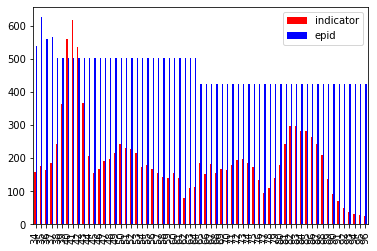

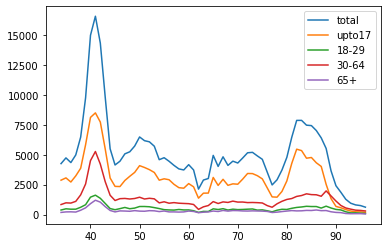

In [32]:
df2.iloc[:, 7:9].plot(kind='bar', color=['red', 'blue'])
df3 = df2.iloc[:, 1:6]
df3.plot()

<Figure size 432x288 with 0 Axes>

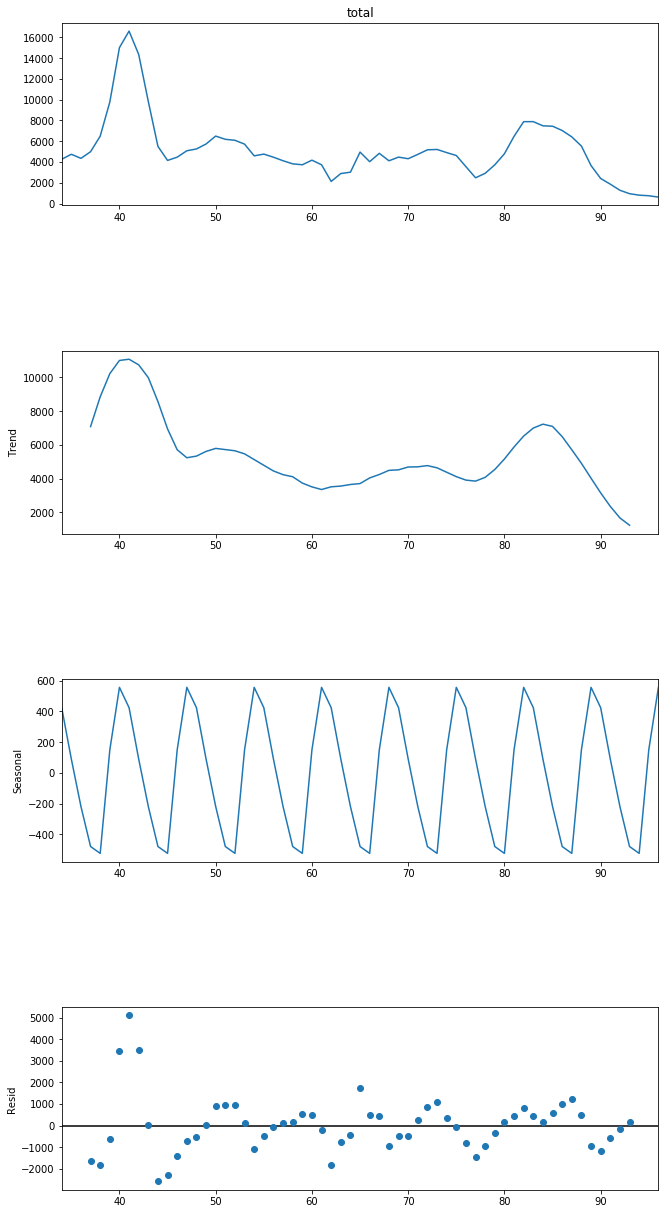

In [33]:
decomposition = seasonal_decompose(df2.total, period=7)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 20)

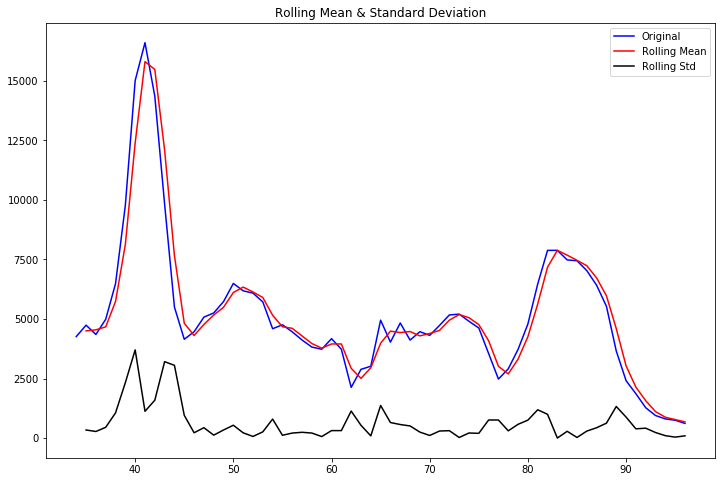

Results of Dickey-Fuller Test:
Test Statistic                 -1.771604
p-value                         0.394648
#Lags Used                      3.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [34]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=2).mean()
    rolstd = pd.Series(timeseries).rolling(window=2).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.total)

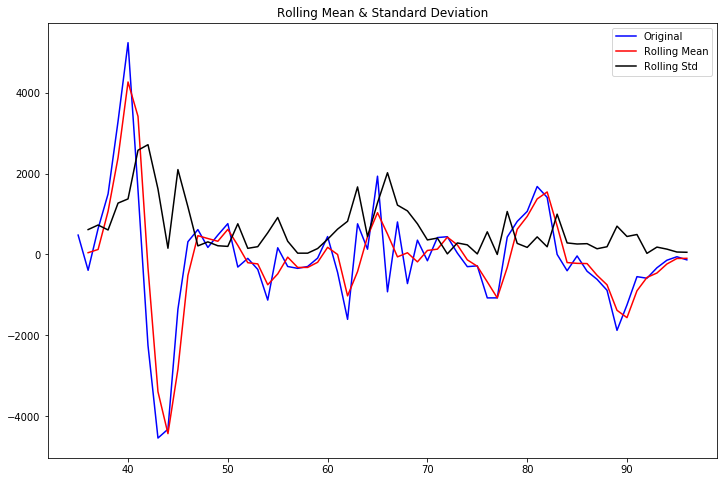

Results of Dickey-Fuller Test:
Test Statistic                -6.111297e+00
p-value                        9.319032e-08
#Lags Used                     2.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [35]:
df2['first_diff'] = df2.total - df2.total.shift(1)
test_stationarity(df2.first_diff.dropna(inplace=False))

In [36]:
# # brute force calculating parameters for SARIMA
# import itertools
# p = range(0,3)
# q = range(0,3)
# d = range(0,2)
# s = range(1,4) # means season duration
# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = list(itertools.product(p, d, q, s))
# # SARIMA model pipeline
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = SARIMAX(df2.first_diff,
#                           order=param,
#                           seasonal_order=param_seasonal)
#             results = mod.fit(max_iter = 20, method = 'powell')
#         except:
#             continue
# print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
# pdq, seasonal_pdq, aic = param, param_seasonal, results.aic
# print(pdq, seasonal_pdq, aic)

In [37]:
# pdq=(2, 1, 2), seasonal_pdq=(2, 1, 2, 32)
print(pdq, seasonal_pdq, aic)
mod = SARIMAX(df2.first_diff, trend='n', order=(1,0,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

NameError: name 'pdq' is not defined

In [ ]:
df2['predict_total'] = results.predict(start=1, end=32, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))